In [1]:
import numpy as np 
import pandas as pd 
import cv2 
import torch 
import torchvision
from torch import nn 
from torchvision import utils as vutils 
from torchvision import transforms 
from torch.nn import functional as F 
from torch.utils import data 
from torch.optim import SGD, Adam 
import torch_metrics
from torch_metrics import dice_loss, BCE, BCE_dice_loss,IoU, BCEWithLogitsLoss 
from torch_metrics import iou_pytorch
from PIL import Image 
import matplotlib.pyplot as plt 
import os 
from statistics import mean 
from torch_metrics import plot_training_scores, plot_validation_scores
from architectures.torch_r2udense import r2udensenet
from architectures.torch_unet import UNet
from data2D_ucsf_1d import load_train_data, load_test_data
import sklearn 
from torchvision.transforms import v2
from sklearn.model_selection import KFold
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
import datetime
import random 
import random 
import pdb 
import scipy.ndimage as ndi 
from tqdm import tqdm



#sanity check metrics and directories 
debug = False
file_no_mask = 0 
maskless_files = []
mask_no_file = 0 
fileless_masks = []

num_negative_diagnoses = 0
num_positive_diagnoses = 0 

img_dimensions = []
msk_dimensions = []

n_files = 0 
densenet_weights_path = '/home/henry/UCSF_Prostate_Segmentation/Weights/densenet_weights/'
unet_weights = '/home/henry/UCSF_Prostate_Segmentation/Weights/UNet_weights/'
plots_save_path = '/home/henry/UCSF_Prostate_Segmentation/Data_plots/Inference_results/'
metrics_save_path = '/home/henry/UCSF_Prostate_Segmentation/Data_plots/metrics_plots/'

#metrics 
composite_loss = []
dice_loss_list = []
dice = []
precison = []
recall = []
auc = []
accuracy = []
IoU_test = []
binaryCE_original = []
bce_list = []

#change these functions to list the name of whichever model we choose to use 
#model name should be a variable 
def get_model_name(k,e): 
    return 'model_r2udensenet'+str(k)+"_"+str(e)+'.hdf5'
def get_log_name(k): 
    return 'log_r2udensenet'+str(k)+'.csv'

def save_model_weights_path (path,model_name): 
    current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    save_path = os.path.join(path,f'{current_time}_#_{model_name}.pth')
    return save_path


#random image augmentation 
def random_augmentation(image,mask): 
    transforms = v2.Compose([
    v2.RandomHorizontalFlip(p=0.5),
    v2.RandomVerticalFlip(p=0.5),
    v2.RandomRotation(degrees=(-15,15))
])
    image = transforms(image)
    mask = transforms(mask)
    return image,mask

#filter out negative diagnoses
def positives_only(x_train,y_train): 
    num_positive = 0 
    num_negative = 0 
    positive_tumor_images = []
    positive_tumor_masks = []
    negative_tumor_images = []
    negative_tumor_masks = []
    for i, mask in enumerate(y_train): 
        j = np.max(y_train[i])
        if j > 0: 
            num_positive += 1
            positive_tumor_images.append(x_train[i])
            positive_tumor_masks.append(y_train[i])
        else: 
            num_negative +=1
            negative_tumor_images.append(x_train[i])
            negative_tumor_masks.append(y_train[i])
    x_train = positive_tumor_images
    y_train = positive_tumor_masks
    return x_train,y_train 


def sanity_check(images,masks): 

    fig, axes = plt.subplots(nrows=4,ncols=2,figsize=(15,15))
    for i in range(0,4): 
        rand = np.random.randint(0,len(images)-1)
        print(f'loaded images dim: {images[rand].shape}')
        print(f'loaded masks dim: {masks[rand].shape}')
        axes[i,0].imshow(images[rand],cmap='gray')
        axes[i,1].imshow(masks[rand],cmap='gray')
    plt.savefig(f'/home/henry/UCSF_Prostate_Segmentation/Data_plots/Sanity_checks/densenet.png')
    plt.show()

def resize_images(data,new_dim,interpolation_order):
    if data.shape[1] < 4:
        x_shape = data.shape[2]
        y_shape = data.shape[3]
        zoomed_data = np.zeros(data.shape[0],data.shape[1],new_dim,new_dim)
        zoom_factor = (1,(new_dim / x_shape),(new_dim / y_shape))
    else: 
        x_shape = data.shape[1]
        y_shape = data.shape[2]
        zoomed_data = np.zeros((data.shape[0],new_dim,new_dim,data.shape[3]))
        zoom_factor = ((new_dim / x_shape),(new_dim / y_shape),1)
    counter = 0 
    for image in tqdm(data,desc='Resizing Data',unit='images'): 
        new_image = ndi.zoom(image,zoom_factor,order=interpolation_order)
        zoomed_data[counter] = new_image
        counter += 1
    return zoomed_data


def dataset_visualization(images,masks): 
    cont_bool = True 
    counter = 0 
    while cont_bool == True and counter < len(images): 
        print(f'Training Example #{counter}')
        fig, axes = plt.subplots(2,1,figsize=(15,15))
        axes[0].imshow(images[counter],cmap='gray')
        axes[1].imshow(masks[counter],cmap='gray')
        plt.show()
        cont_state = int(input('Type 1 to continue or 0 to exit: '))
        if cont_state == 1: 
            counter += 1
            continue 
        else:
            cont_state = False 

def normalization(data): 
    data_mean = np.mean(data)
    data_std = np.std(data)
    data_normalized = (data - data_mean)/data_std
    return data_normalized

class torch_loader(data.Dataset): 

    def __init__(self,inputs,transform=None): 
        self.inputs = inputs
        self.transform = transform 
        self.input_dtype = torch.float32
        self.target_dtype = torch.float32

    def __len__(self): 
        return len(self.inputs)
    
    def __getitem__(self,index): 
        image_array, mask_array = self.inputs[0]
        x = torch.from_numpy(np.transpose((np.array(image_array)),(2,0,1))).type(self.input_dtype)
        y = torch.from_numpy(np.transpose((np.array(mask_array)),(2,0,1))).type(self.target_dtype)

        if self.transform is not None: 
            x = self.transform(x)
            y = self.transform(y)

        return x, y





#creates training and datasets in torch tensor form
#check that this returns the same datatype and the same shape as the one that worked with the other network 
def generate_dataset(positive_bool,augmentation_bool, augmentation_prob,val_size): 

    dtype = torch.float64

    x_train, y_train = load_train_data()
    x_test, y_test = load_test_data()
    y_test = np.expand_dims(np.array(y_test),axis=-1)
    print('entering resizing')
    x_train = resize_images(x_train,256,4)
    y_train = resize_images(y_train,256,0)
    x_test = resize_images(x_test,256,4)
    y_test = resize_images(y_test,256,0)


    x_train= normalization(x_train)
    x_test = normalization(x_test)
    y_train = y_train.astype(np.float32) / 255.
    y_test = y_test.astype(np.float32) / 255.



    if positive_bool: 
        x_train, y_train = positives_only(x_train,y_train)
        x_test,y_test = positives_only(x_test,y_test)

    sanity_check(x_train,y_train)

        
    if augmentation_bool: 
        for i in range(0,len(x_train)-1): 
            prob = random.random()
            if prob < augmentation_prob: 
                im = x_train[i]
                mask = y_train[i]
                aug_im, aug_mask = random_augmentation(im,mask)
                x_train[i] = aug_im
                y_train[i] = aug_mask
            else: 
                pass 

    train_loader_data = [(x_train[i],y_train[i])for i in range(len(x_train)-1)]
    test_loader_data = [(x_test[i],y_test[i])for i in range(len(x_test)-1)]
    train_data = torch_loader(train_loader_data)
    test_data = torch_loader(test_loader_data)

    return train_data,test_data
 
def train_val_loader(train_dataset, val_amount,batch_size): 
    validation_length = int(val_amount * len(train_dataset))
    remainder = validation_length % batch_size
    if remainder != 0: 
        validation_length - remainder
    train_set,val_set = data.random_split(train_dataset,[len(train_dataset)-validation_length,validation_length])

    train_loader = data.DataLoader(dataset=train_set,batch_size=batch_size,shuffle=True)
    val_loader = data.DataLoader(dataset=val_set,batch_size=batch_size,shuffle=True)

    return train_loader,val_loader



----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 32, 256, 256]             288
       BatchNorm2d-2         [-1, 32, 256, 256]              64
              ReLU-3         [-1, 32, 256, 256]               0
           Dropout-4         [-1, 32, 256, 256]               0
       Convolution-5         [-1, 32, 256, 256]               0
            Conv2d-6         [-1, 32, 256, 256]              32
       BatchNorm2d-7         [-1, 32, 256, 256]              64
              ReLU-8         [-1, 32, 256, 256]               0
            Conv2d-9         [-1, 32, 256, 256]           9,216
      BatchNorm2d-10         [-1, 32, 256, 256]              64
             ReLU-11         [-1, 32, 256, 256]               0
          Dropout-12         [-1, 32, 256, 256]               0
      Convolution-13         [-1, 32, 256, 256]               0
             ReLU-14         [-1, 32, 2

In [2]:
def train(model_name,model,optimizer,criterion,spec_loss,train_loader,val_loader,device,num_epochs,clear_mem=True):

    torch.cuda.empty_cache() 
    print('Model sent to '+str(device))
    model.to(device)
    train_losses=[]
    train_scores = []
    iters = 0
    for epoch in range(num_epochs): 
        print(f"Epoch {epoch+1} / {num_epochs}")
        model.train()
        for i, batch in enumerate(train_loader): 
            img = batch[0].float().to(device)
            msk = batch[1].float().to(device)
            optimizer.zero_grad()
            output = model(img)
            loss = criterion(output,msk)
            print(f'Epoch {epoch+1}/{num_epochs} BCE with Logits Loss: {loss}')
            loss.backward()
            optimizer.step()
            train_losses.append(loss)
            #need to fill this in with the loss function
            #train_scores.append(spec_loss(output.detach(),msk))
            iters += 1

    model.eval()
    val_losses = []
    val_scores = []
    val_preds = []
    val_labels = []

    with torch.no_grad():
        for i, batch in enumerate(val_loader): 
            torch.cuda.empty_cache()
            img = batch[0].float()
            img = img.to(device)
            msk = batch[1].float()
            msk = msk.to(device)
            optimizer.zero_grad()
            val_labels.append(msk)
            output = model(img)
            val_preds.append(output)
            loss = criterion(output,msk)
            #need to fill this in with the loss function 
            val_scores.append(spec_loss(output.detach(),msk))
            val_scores.append(loss.item())

    torch.cuda.empty_cache()


    results = {
        'model_name' : model_name,
        'train_losses': train_losses,
        'train_scores': train_scores,
        'val_losses': val_losses,
        'val_scores': val_scores, 

    }
    save_path = save_model_weights_path(densenet_weights_path,f'{num_epochs}')
    torch.save(model.state_dict(),save_path)

    if clear_mem: 
        del model 
        del optimizer 
        del criterion 
        torch.cuda.empty_cache()

    return results 


def visualize_segmentation(model,data_loader,logits_bool, num_samples=5,device='cuda'): 
    fig, axes = plt.subplots(num_samples,3,figsize=(15,15))
    num_samples_count = 0 
    for ax, col in zip(axes[0],['MRI','Ground Truth','Predicted Mask']): 
        ax.set_title(col)
    index=0
    model.eval()
    for i, batch in enumerate(data_loader): 
        print(i)
        img = batch[0].float()
        img = img.to(device)
        msk = batch[1].float()
        msk = msk.to(device)
        output = model(img)
        output = F.sigmoid(output)
        if logits_bool: 
            output = torch.squeeze(output[0], dim=0).detach().cpu().numpy()
            output = (output * 255).astype(np.int16)
        else:
            output = torch.squeeze(output[0], dim=0).detach().cpu().numpy()

        if i % 35 == 0: 
            axes[num_samples_count,0].imshow(torch.squeeze(img[0],dim=0).detach().cpu().numpy(),
                             cmap='gray',interpolation='none')
            axes[num_samples_count,1].imshow(torch.squeeze(msk[0],dim=0).detach().cpu().numpy(),
                            cmap='gray',interpolation='none')
            axes[num_samples_count, 2].imshow(output,
                                                  cmap='gray', interpolation='none')
            print(np.unique(output))
            num_samples_count += 1
        if num_samples_count >= (num_samples)-1:
            break

    plt.tight_layout()
    current_time = datetime.datetime.now().strftime('%Y-%m-%d_%H-%M-%S')
    plt.savefig(f'{plots_save_path}{current_time}')





========== Loading of ALL UCSF Training Data ==============
====== Loading of ALL UCSF Test Data with Tumors =======
entering resizing


Resizing Data: 100%|██████████| 177/177 [00:00<00:00, 1355.98images/s]


loaded images dim: (256, 256, 1)
loaded masks dim: (256, 256, 1)
loaded images dim: (256, 256, 1)
loaded masks dim: (256, 256, 1)
loaded images dim: (256, 256, 1)
loaded masks dim: (256, 256, 1)
loaded images dim: (256, 256, 1)
loaded masks dim: (256, 256, 1)


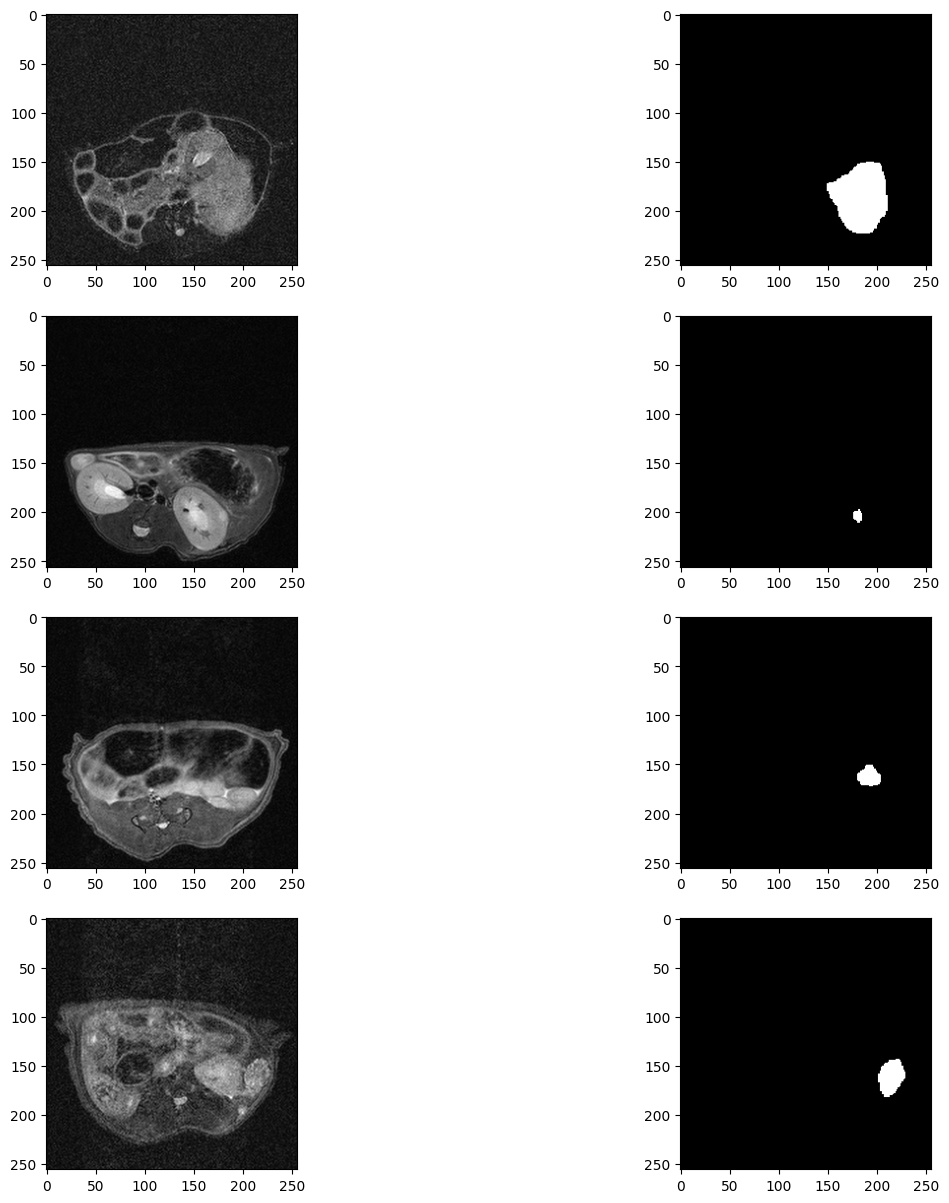

In [4]:
train_set,test_set = generate_dataset(positive_bool=True,augmentation_bool=False,
                                      augmentation_prob=None,val_size=0.1)
train_loader,val_loader = train_val_loader(train_set,0.2,batch_size=2)
visualization_loader,forget = train_val_loader(train_set,0.2,batch_size=2)

Model sent to cuda
Epoch 1 / 2
Epoch 1/2 BCE with Logits Loss: 0.6491861343383789
Epoch 1/2 BCE with Logits Loss: 0.651846170425415
Epoch 1/2 BCE with Logits Loss: 0.6502050161361694
Epoch 1/2 BCE with Logits Loss: 0.649303138256073
Epoch 1/2 BCE with Logits Loss: 0.6462365388870239
Epoch 1/2 BCE with Logits Loss: 0.6468664407730103
Epoch 1/2 BCE with Logits Loss: 0.6470593214035034
Epoch 1/2 BCE with Logits Loss: 0.6461814641952515
Epoch 1/2 BCE with Logits Loss: 0.6423518657684326
Epoch 1/2 BCE with Logits Loss: 0.6469950079917908
Epoch 1/2 BCE with Logits Loss: 0.6455804109573364
Epoch 1/2 BCE with Logits Loss: 0.6443862318992615
Epoch 1/2 BCE with Logits Loss: 0.6442140340805054
Epoch 1/2 BCE with Logits Loss: 0.6482589244842529
Epoch 1/2 BCE with Logits Loss: 0.6451679468154907
Epoch 1/2 BCE with Logits Loss: 0.6461910009384155
Epoch 1/2 BCE with Logits Loss: 0.6450799703598022
Epoch 1/2 BCE with Logits Loss: 0.6454765796661377
Epoch 1/2 BCE with Logits Loss: 0.642831563949585
Epo

AttributeError: 'numpy.ndarray' object has no attribute 'plot'

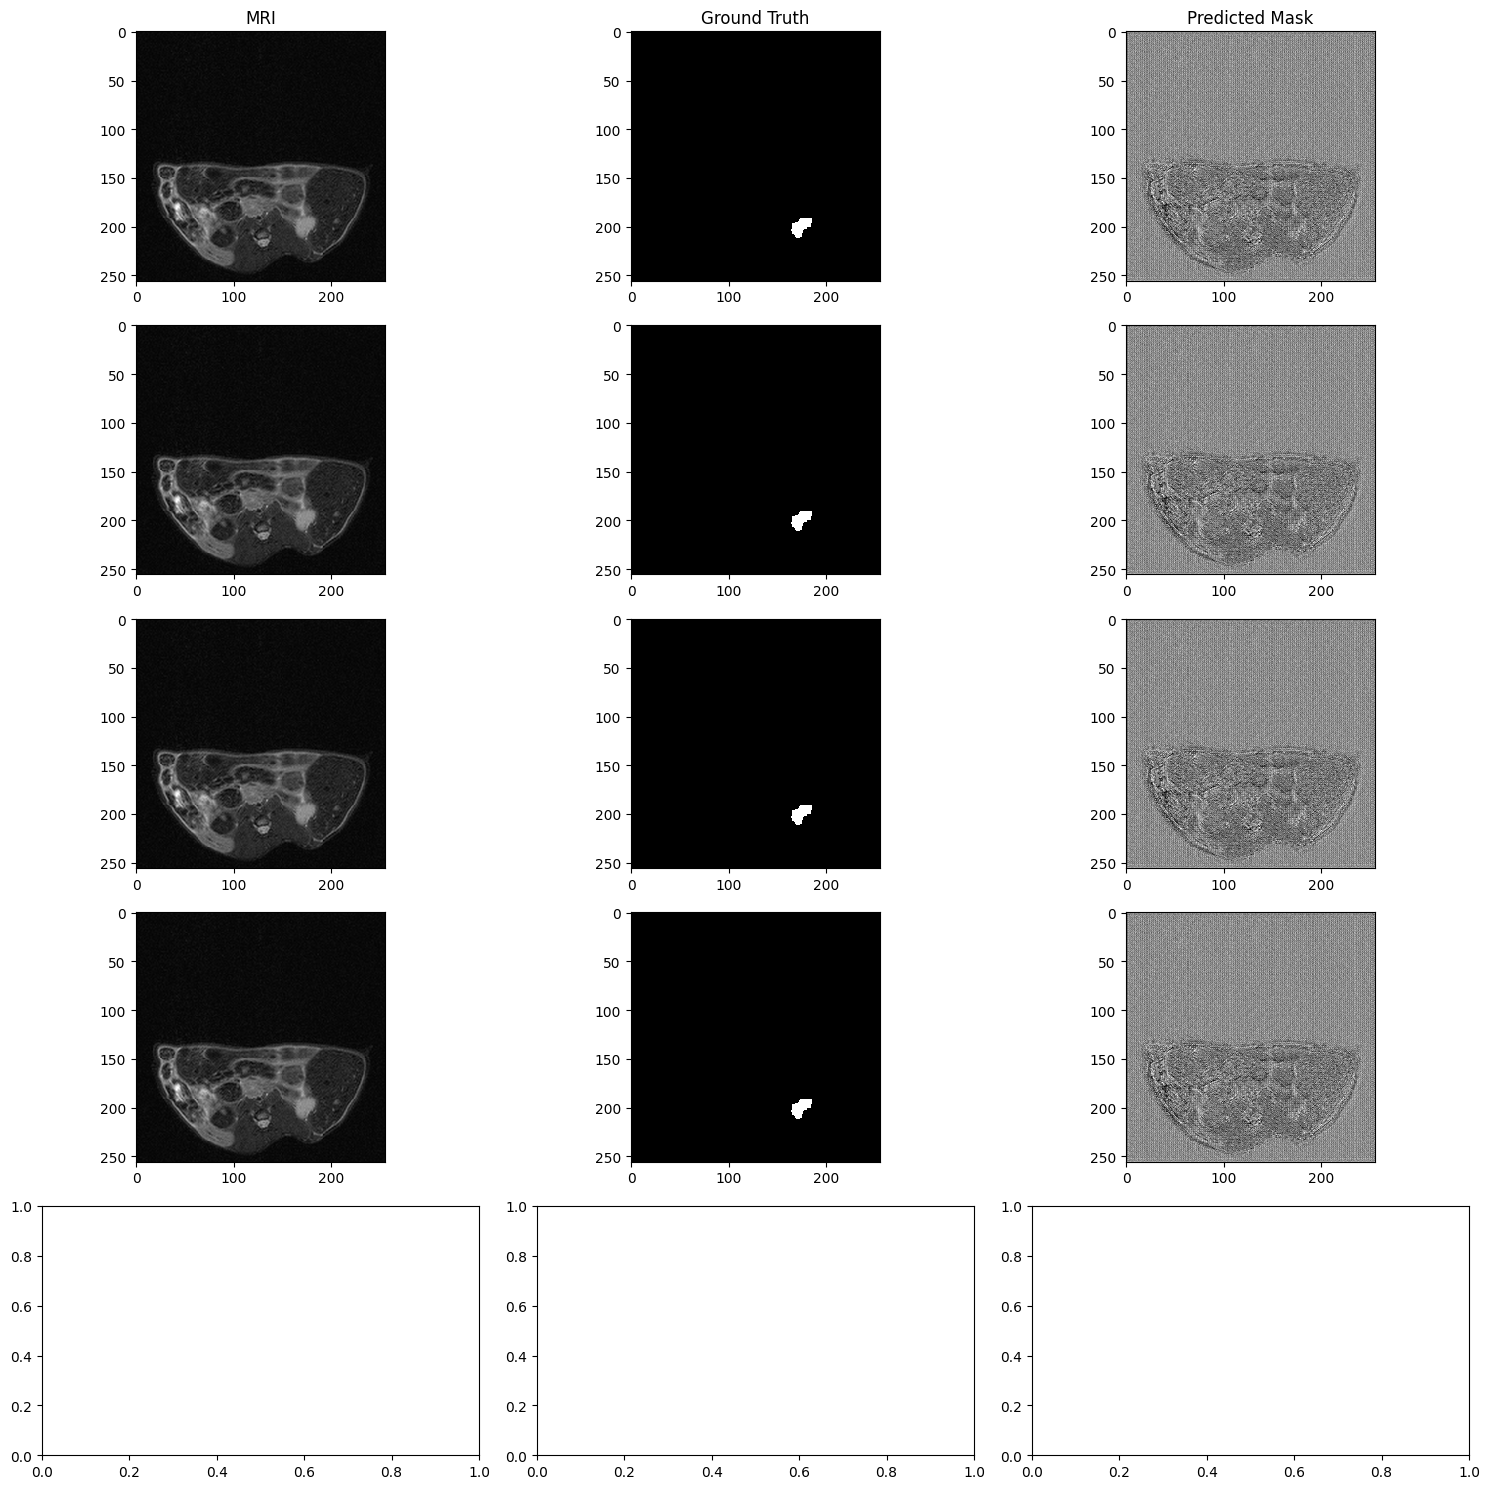

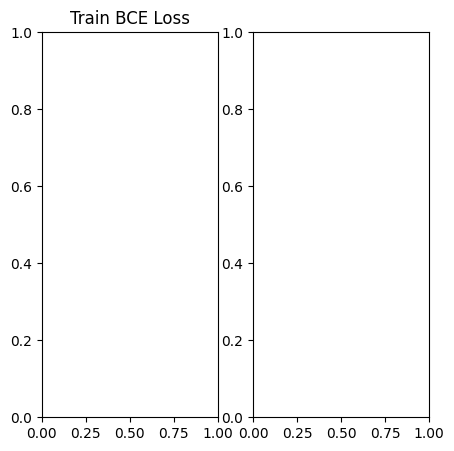

In [10]:

def create_model():
    model = r2udensenet()
    for name, module in model.named_modules():
        if isinstance(module, nn.Linear) and hasattr(module, 'weight'):
            torch.nn.init.xavier_uniform_(module.weight)
    return model

model = create_model()
model_name = 'r2udensenet'
spec_loss = nn.BCEWithLogitsLoss()
#optimizer = torch.optim.Adam(model.parameters(),lr=1e-5)
optimizer = SGD(model.parameters(),lr=1e-5,momentum=0.9)
criterion = nn.BCEWithLogitsLoss()
if debug: 
    device = 'cpu'
else: 
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
num_epochs = 2
results = train('run2',model,optimizer,criterion,
                spec_loss,train_loader,val_loader,device,
                num_epochs=num_epochs,clear_mem=True)

visualize_segmentation(model,val_loader,logits_bool=False,num_samples=5,device=device)
plot_training_scores(results['train_scores'],results['train_scores'],metrics_save_path)
plot_validation_scores(results['val_scores'],results['val_losses'],metrics_save_path)
